In [26]:
# Import required libraries

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
from plotly.graph_objs import *
plotly.offline.init_notebook_mode()
import geopandas
import seaborn as sns
from matplotlib import pylab

sns.set()

In [3]:
# Load dataset
df = pd.read_csv('df.csv').drop(['Unnamed: 0'],axis=1)
df.head()

InvoiceNo StockCode  Quantity      InvoiceDate  UnitPrice CustomerID  \
0    536365    85123A         6  2010-12-01 8:26       2.55     C17850   
1    536365     71053         6  2010-12-01 8:26       3.39     C17850   
2    536365    84406B         8  2010-12-01 8:26       2.75     C17850   
3    536365    84029G         6  2010-12-01 8:26       3.39     C17850   
4    536365    84029E         6  2010-12-01 8:26       3.39     C17850   

          Country                          Description  CancelledOrder  \
0  United Kingdom   CREAM HANGING HEART T-LIGHT HOLDER               0   
1  United Kingdom                  WHITE METAL LANTERN               0   
2  United Kingdom       CREAM CUPID HEARTS COAT HANGER               0   
3  United Kingdom  KNITTED UNION FLAG HOT WATER BOTTLE               0   
4  United Kingdom       RED WOOLLY HOTTIE WHITE HEART.               0   

   InternationalOrders  TotalPrice  
0                    0       15.30  
1                    0       20.34  
2                    0       22.00  
3                    0       20.34  
4                    0       20.34

## Exploratory Data Analysis

In [4]:
# Load file for plotting on world map
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 177 entries, 0 to 176
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   pop_est     177 non-null    int64   
 1   continent   177 non-null    object  
 2   name        177 non-null    object  
 3   iso_a3      177 non-null    object  
 4   gdp_md_est  177 non-null    float64 
 5   geometry    177 non-null    geometry
dtypes: float64(1), geometry(1), int64(1), object(3)
memory usage: 8.4+ KB


In [5]:
# Match country names in df dataset and world dataframe

Countries = pd.DataFrame(df.Country.unique(),columns=['Country'])
Countries[~Countries.Country.isin(list(world.name))]

Country
6              EIRE
16  Channel Islands
24        Singapore
28   Czech Republic
31              USA
32          Bahrain
33            Malta
34              RSA

In [6]:
# Sync country names in df and world datasets
df.Country.replace(to_replace={'EIRE':'Ireland','Channel Islands':'United Kingdom','Czech Republic':'Czech Rep.',
                       'RSA':'South Africa','Bahrain':'Saudi Arabia','Malta':'Italy'},inplace=True)
world.name.replace(to_replace={'Malaysia':'Singapore','United States':'USA'},inplace=True)
                       

In [27]:
def plotOnMap(world,colname,title):
    
    colormap = 'magma_r'
    ax = world.plot(column=colname, cmap=colormap, figsize=[18,12], edgecolor='gray', 
                    vmin=min(world[colname]),vmax=max(world[colname]))
    # map marginal/face deco
    ax.set_title('Distribution of International '+title+' (outside UK)',fontsize=17)
    ax.grid() 
    # colorbar will be created by ...
    fig = ax.get_figure()
    # add colorbar axes to the figure
    # here, need trial-and-error to get [l,b,w,h] right
    # l:left, b:bottom, w:width, h:height; in normalized unit (0-1)
    cbax = fig.add_axes([0.95, 0.3, 0.03, 0.39])   
    cbax.set_title('Number of '+title)
    sm = plt.cm.ScalarMappable(cmap=colormap, \
                    norm=plt.Normalize(vmin=min(world[colname]), vmax=max(world[colname])))
    # at this stage, 
    # 'cbax' is just a blank axes, with un needed labels on x and y axes
    # blank-out the array of the scalar mappable 'sm'
    sm._A = []
    # draw colorbar into 'cbax'
    fig.colorbar(sm, cax=cbax, format="%d")
    # dont use: plt.tight_layout()
    plt.show()

In [8]:
def plotPie(pie_df,colname,title):
    fig = plt.figure(figsize=(5,5))

    colors = ['navajowhite', 'sandybrown']
    plt.pie(pie_df[colname],labels=pie_df.location,autopct='%1.1f%%',colors=colors)
    plt.title(title.title()+' Percentage in UK and outside UK')
    
    plt.tight_layout()
    plt.show()

In [9]:
def addToWorld(world,col,colname,title):

    if col==None:
        temp_df = df[df.CancelledOrder==1].Country.value_counts().to_frame(colname).reset_index()
    else:
        temp_df = df.groupby(['Country',col],as_index=False).count().Country.value_counts().to_frame(colname).reset_index()
    
    world = pd.merge(world, temp_df, left_on='name', right_on='index', how='left', validate='one_to_one')

    world.drop('index', axis=1, inplace=True)
    world[colname].fillna(0,inplace=True)
    
    temp_df['location'] = np.where(temp_df['index']=='United Kingdom', 'UK', 'Rest of the World')
    pie_df = temp_df.groupby(['location'],as_index=False)[colname].sum()
    plotPie(pie_df,colname,title)
    
    world.loc[world.name=='United Kingdom',colname] = 0
    plotOnMap(world,colname,title)

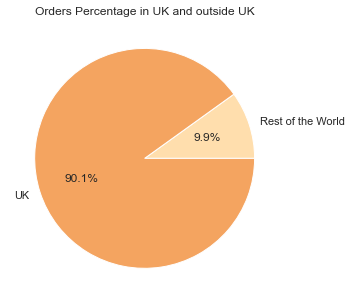

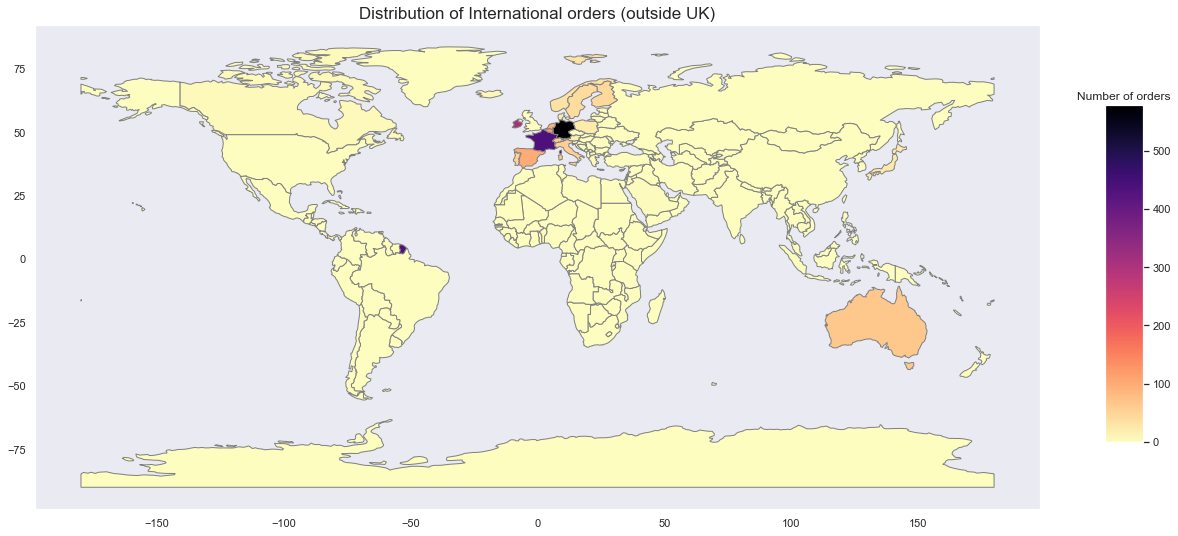

In [10]:
addToWorld(world,'InvoiceNo','TotalOrders','orders')

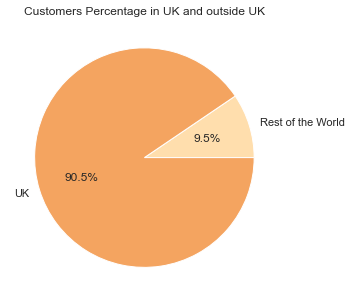

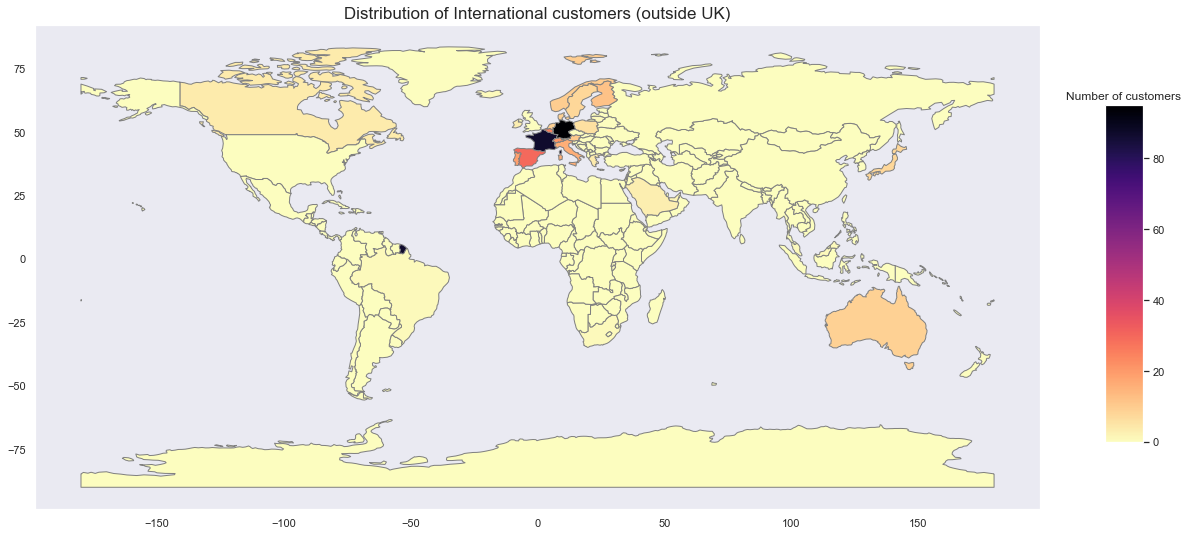

In [11]:
addToWorld(world,'CustomerID','TotalCust','customers')

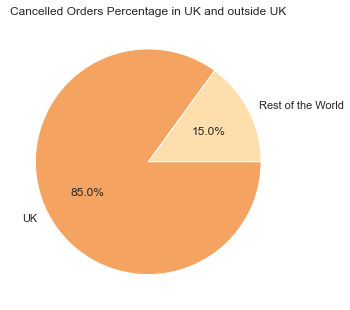

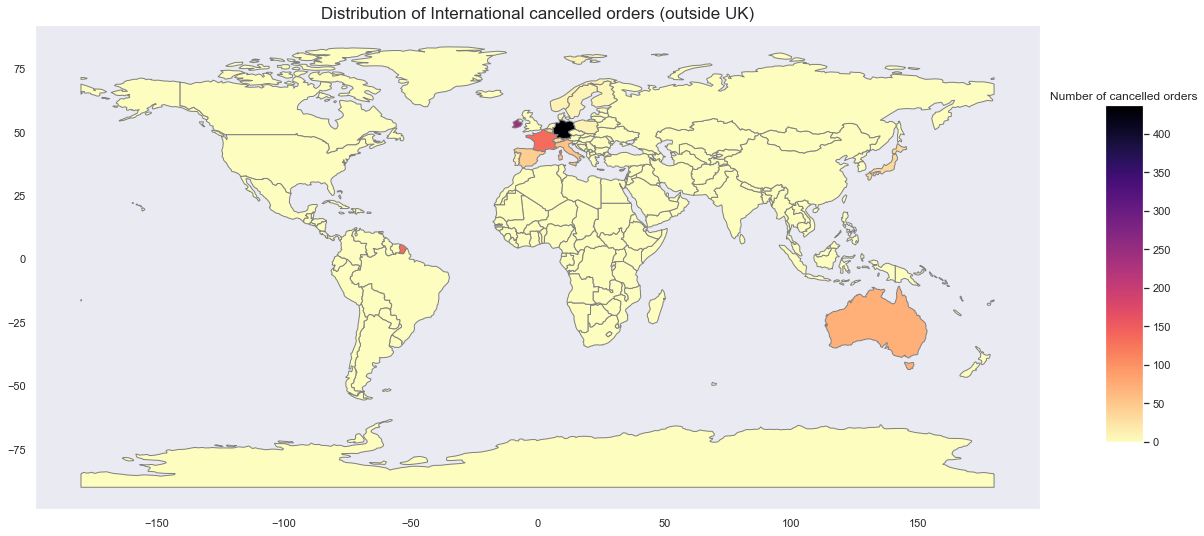

In [12]:
addToWorld(world,None,'Cancelled','cancelled orders')

<ipython-input-13-da3d169c92fd>:3: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



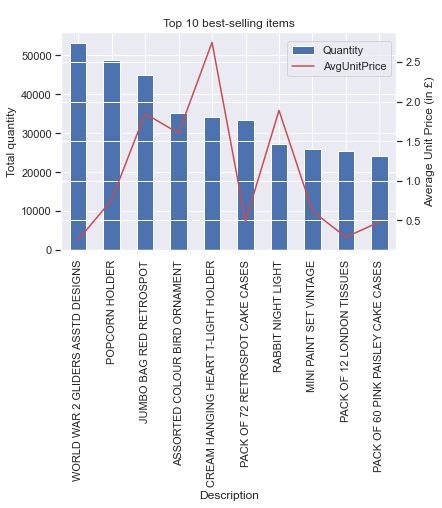

In [13]:
# Find the 10 best-selling items

Top10Qty = df.groupby('Description',as_index=False)['Quantity','TotalPrice'].sum().sort_values(by='Quantity',
                                                                                               ascending=False).head(10)
Top10Qty['AvgUnitPrice'] = Top10Qty.TotalPrice/Top10Qty.Quantity

# Plot top 10 most popular items
ax = Top10Qty.plot(x="Description", y="Quantity", legend=False,kind='bar')
ax2 = ax.twinx()
Top10Qty.plot(x="Description", y="AvgUnitPrice", ax=ax2, legend=False, color="r")
ax.figure.legend(loc=(.65,.85))
plt.title('Top 10 best-selling items')
ax.set_ylabel('Total quantity')
ax2.set_ylabel('Average Unit Price (in £)')
plt.show()

<ipython-input-14-ebb0b296a9dd>:3: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



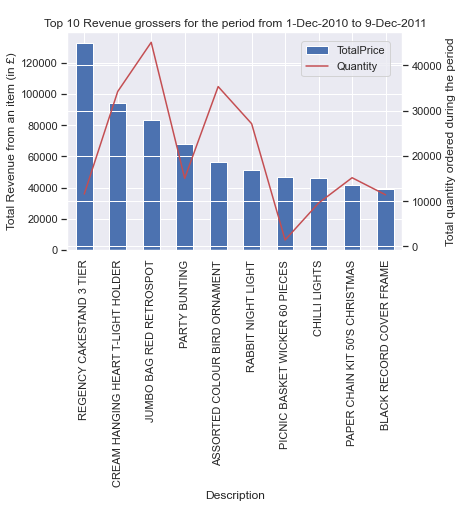

In [14]:
# Top 10 revenue grossing items

Top10Rev = df.groupby('Description',as_index=False)['TotalPrice','Quantity'].sum().sort_values(by='TotalPrice',
                                                                                               ascending=False).head(10)
Top10Rev['AvgUnitPrice'] = Top10Rev.TotalPrice/Top10Rev.Quantity

# Total Revenue
TotalRev = round(df.TotalPrice.sum(),0)

# Plot top 10 revenue grossers
ax = Top10Rev.plot(x="Description", y="TotalPrice", legend=False,kind='bar')
ax2 = ax.twinx()
Top10Rev.plot(x="Description", y="Quantity", ax=ax2, legend=False, color="r")
# ax.axhline(TotalRev, c='k', ls='--')
ax.figure.legend(loc=(.65,.85))
plt.title('Top 10 Revenue grossers for the period from 1-Dec-2010 to 9-Dec-2011')
ax.set_ylabel('Total Revenue from an item (in £)')
ax2.set_ylabel('Total quantity ordered during the period')
plt.show()

In [15]:
# Number of unique items and customers

print(len(df.Description.unique()))
print(len(df.CustomerID.unique()))

3652
4357


### Time Series plots

In [22]:
sales = df.groupby('InvoiceDate')['TotalPrice'].sum()
sales.index = pd.to_datetime(sales.index)


In [23]:
def plotSales(sales,time_freq,xtick,freq):
    trend = sales.resample(time_freq).sum()
    holidays = ['2010-12-27', '2010-12-28', '2011-01-03', '2011-04-22', '2011-04-25', '2011-04-29', '2011-05-02',
            '2011-05-30', '2011-08-29']

    fig = plt.figure(figsize=(20, 5))

    plt.plot(trend)

    dates = trend.index[::xtick]
    labels = dates.strftime('%b %d %H:%M %A')
    
    if time_freq!='H':
        [pylab.axvline(_x, linewidth=1, color='r',ls='--') for _x in holidays]
        labels = dates.strftime('%b %d')

    plt.xticks(dates, labels, rotation=90)
    plt.legend(['TotalPrice','UK Holidays'])
    plt.title(freq+' sales from Dec-1-2010 to Dec-09-2011')
    plt.show()

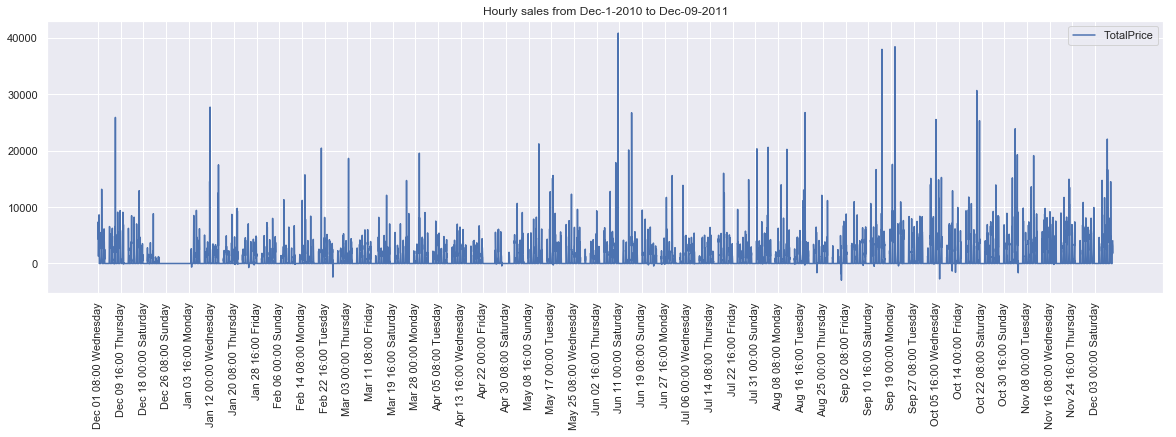

In [25]:
plotSales(sales,'H',200,'Hourly')

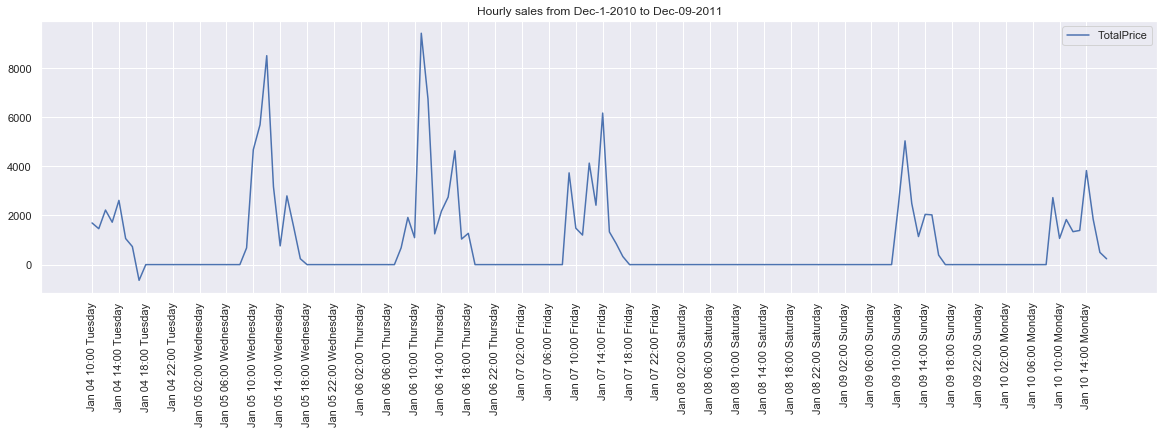

In [26]:
plotSales(sales['2011-01-01':'2011-01-10'],'H',4,'Hourly')

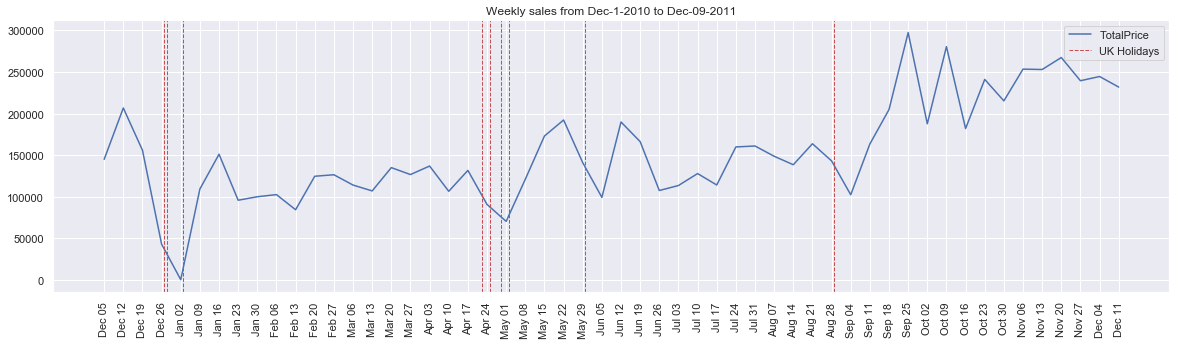

In [27]:
plotSales(sales,'W',1,'Weekly')

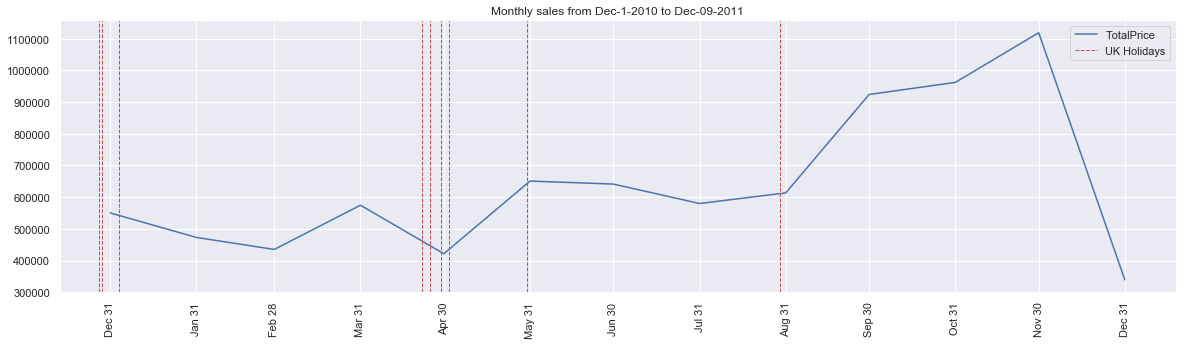

In [28]:
plotSales(sales,'M',1,'Monthly')

In [25]:
df.to_csv('orders.csv')